In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv'
if not os.path.exists('data.csv'):
    data = data
    !wget $data -O data-week-3.csv


--2025-03-14 02:10:34--  https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-03-churn-prediction/WA_Fn-UseC_-Telco-Customer-Churn.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 977501 (955K) [text/plain]
Saving to: ‘data-week-3.csv’

data-week-3.csv     100%[===================>] 954.59K  --.-KB/s    in 0.02s   

2025-03-14 02:10:36 (43.1 MB/s) - ‘data-week-3.csv’ saved [977501/977501]



### Preparing 
1. Read CSV
2. Standardize column names (lower case and replace spaces with underscore)
3. Standardize categorical values (same as 2.)
4. Display transpose since there are a lot of columns, it's easier to see it that way in a list

In [4]:
df = pd.read_csv('data-week-3.csv')
df.head()
df.columns = df.columns.str.lower().str.replace(' ', '_')
categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')
df.head().T

,0,1,2,3,4
customerid,7590-vhveg,5575-gnvde,3668-qpybk,7795-cfocw,9237-hqitu
gender,female,male,male,male,female
seniorcitizen,0,0,0,0,0
partner,yes,no,no,no,no
dependents,no,no,no,no,no
tenure,1,34,2,45,2
phoneservice,no,yes,yes,no,yes
multiplelines,no_phone_service,no,no,no_phone_service,no
internetservice,dsl,dsl,dsl,dsl,fiber_optic
onlinesecurity,no,yes,yes,yes,no


In [5]:
df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)
df.dtypes

customerid           object
gender               object
seniorcitizen         int64
partner              object
dependents           object
tenure                int64
phoneservice         object
multiplelines        object
internetservice      object
onlinesecurity       object
onlinebackup         object
deviceprotection     object
techsupport          object
streamingtv          object
streamingmovies      object
contract             object
paperlessbilling     object
paymentmethod        object
monthlycharges      float64
totalcharges        float64
churn                object
dtype: object

In [6]:
df.churn = ((df.churn == 'yes').astype(int))


In [7]:
df.head(100).churn

0     0
1     0
2     1
3     0
4     1
     ..
95    1
96    0
97    1
98    0
99    1
Name: churn, Length: 100, dtype: int64

### Setting up the validation framework

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [10]:
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)
len(df_train), len(df_val), len(df_test)

(4225, 1409, 1409)

In [11]:
df_train = df_train.reset_index()
df_val = df_val.reset_index()
df_test = df_test.reset_index()

In [12]:
y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

### EDA

In [172]:
df_full_train = df_full_train.reset_index(drop=True)
df_full_train.isnull().sum()

customerid          0
gender              0
seniorcitizen       0
partner             0
dependents          0
tenure              0
phoneservice        0
multiplelines       0
internetservice     0
onlinesecurity      0
onlinebackup        0
deviceprotection    0
techsupport         0
streamingtv         0
streamingmovies     0
contract            0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
churn               0
dtype: int64

In [173]:
df_full_train.churn.value_counts(normalize=True)

churn
0    0.730032
1    0.269968
Name: proportion, dtype: float64

### Feature importance

In [174]:
global_churn_rate = df_full_train.churn.mean()
round(global_churn_rate, 2)

np.float64(0.27)

In [175]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']


In [176]:
df_full_train.columns

Index(['customerid', 'gender', 'seniorcitizen', 'partner', 'dependents',
       'tenure', 'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'churn'],
      dtype='object')

In [177]:
categorical = ['gender', 'seniorcitizen', 'partner', 'dependents',
       'phoneservice', 'multiplelines', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'contract', 'paperlessbilling',
       'paymentmethod']

In [178]:
df_full_train[categorical].nunique()

gender              2
seniorcitizen       2
partner             2
dependents          2
phoneservice        2
multiplelines       3
internetservice     3
onlinesecurity      3
onlinebackup        3
deviceprotection    3
techsupport         3
streamingtv         3
streamingmovies     3
contract            3
paperlessbilling    2
paymentmethod       4
dtype: int64

In [179]:
df_full_train.head()

,customerid,gender,seniorcitizen,partner,dependents,tenure,phoneservice,multiplelines,internetservice,onlinesecurity,...,deviceprotection,techsupport,streamingtv,streamingmovies,contract,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churn
0,5442-pptjy,male,0,yes,yes,12,yes,no,no,no_internet_service,...,no_internet_service,no_internet_service,no_internet_service,no_internet_service,two_year,no,mailed_check,19.70,258.35,0
1,6261-rcvns,female,0,no,no,42,yes,no,dsl,yes,...,yes,yes,no,yes,one_year,no,credit_card_(automatic),73.90,3160.55,1
2,2176-osjuv,male,0,yes,no,71,yes,yes,dsl,yes,...,no,yes,no,no,two_year,no,bank_transfer_(automatic),65.15,4681.75,0
3,6161-erdgd,male,0,yes,yes,71,yes,yes,dsl,yes,...,yes,yes,yes,yes,one_year,no,electronic_check,85.45,6300.85,0
4,2364-ufrom,male,0,no,no,30,yes,no,dsl,yes,...,no,yes,yes,no,one_year,no,electronic_check,70.40,2044.75,0


In [180]:
churn_female = df_full_train[df_full_train.gender == 'female'].churn.mean()
churn_female

np.float64(0.27682403433476394)

In [181]:
churn_male = df_full_train[df_full_train.gender == 'male'].churn.mean()
churn_male

np.float64(0.2632135306553911)

In [182]:
global_churn = df_full_train.churn.mean()

In [183]:
from IPython.display import display
for c in categorical:
    print(c)
    df_group = df_full_train.groupby(c).churn.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean'] - global_churn
    df_group['risk'] = df_group['mean'] / global_churn
    display(df_group)
    print()
    print()


gender


,mean,count,diff,risk
gender,,,,
female,0.276824,2796,0.006856,1.025396
male,0.263214,2838,-0.006755,0.974980




seniorcitizen


,mean,count,diff,risk
seniorcitizen,,,,
0,0.242270,4722,-0.027698,0.897403
1,0.413377,912,0.143409,1.531208




partner


,mean,count,diff,risk
partner,,,,
no,0.329809,2932,0.059841,1.221659
yes,0.205033,2702,-0.064935,0.759472




dependents


,mean,count,diff,risk
dependents,,,,
no,0.313760,3968,0.043792,1.162212
yes,0.165666,1666,-0.104302,0.613651




phoneservice


,mean,count,diff,risk
phoneservice,,,,
no,0.241316,547,-0.028652,0.893870
yes,0.273049,5087,0.003081,1.011412




multiplelines


,mean,count,diff,risk
multiplelines,,,,
no,0.257407,2700,-0.012561,0.953474
no_phone_service,0.241316,547,-0.028652,0.893870
yes,0.290742,2387,0.020773,1.076948




internetservice


,mean,count,diff,risk
internetservice,,,,
dsl,0.192347,1934,-0.077621,0.712482
fiber_optic,0.425171,2479,0.155203,1.574895
no,0.077805,1221,-0.192163,0.288201




onlinesecurity


,mean,count,diff,risk
onlinesecurity,,,,
no,0.420921,2801,0.150953,1.559152
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.153226,1612,-0.116742,0.567570




onlinebackup


,mean,count,diff,risk
onlinebackup,,,,
no,0.404323,2498,0.134355,1.497672
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.217232,1915,-0.052736,0.804660




deviceprotection


,mean,count,diff,risk
deviceprotection,,,,
no,0.395875,2473,0.125907,1.466379
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.230412,1940,-0.039556,0.853480




techsupport


,mean,count,diff,risk
techsupport,,,,
no,0.418914,2781,0.148946,1.551717
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.159926,1632,-0.110042,0.592390




streamingtv


,mean,count,diff,risk
streamingtv,,,,
no,0.342832,2246,0.072864,1.269897
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.302723,2167,0.032755,1.121328




streamingmovies


,mean,count,diff,risk
streamingmovies,,,,
no,0.338906,2213,0.068938,1.255358
no_internet_service,0.077805,1221,-0.192163,0.288201
yes,0.307273,2200,0.037305,1.138182




contract


,mean,count,diff,risk
contract,,,,
month-to-month,0.431701,3104,0.161733,1.599082
one_year,0.120573,1186,-0.149395,0.446621
two_year,0.028274,1344,-0.241694,0.104730




paperlessbilling


,mean,count,diff,risk
paperlessbilling,,,,
no,0.172071,2313,-0.097897,0.637375
yes,0.338151,3321,0.068183,1.252560




paymentmethod


,mean,count,diff,risk
paymentmethod,,,,
bank_transfer_(automatic),0.168171,1219,-0.101797,0.622928
credit_card_(automatic),0.164339,1217,-0.105630,0.608733
electronic_check,0.455890,1893,0.185922,1.688682
mailed_check,0.193870,1305,-0.076098,0.718121


#### Mutual information

In [184]:
from sklearn.metrics import mutual_info_score

In [185]:
mutual_info_score(df_full_train.churn, df_full_train.contract)

np.float64(0.0983203874041556)

In [186]:
mutual_info_score(df_full_train.gender, df_full_train.churn)

np.float64(0.0001174846211139946)

In [187]:
mutual_info_score(df_full_train.partner, df_full_train.churn)

np.float64(0.009967689095399745)

In [188]:
def mutual_info_churn_score(series):
    return mutual_info_score(series, df_full_train.churn)
mi = df_full_train[categorical].apply(mutual_info_churn_score)
mi.sort_values(ascending=False)

contract            0.098320
onlinesecurity      0.063085
techsupport         0.061032
internetservice     0.055868
onlinebackup        0.046923
deviceprotection    0.043453
paymentmethod       0.043210
streamingtv         0.031853
streamingmovies     0.031581
paperlessbilling    0.017589
dependents          0.012346
partner             0.009968
seniorcitizen       0.009410
multiplelines       0.000857
phoneservice        0.000229
gender              0.000117
dtype: float64

In [189]:
df_full_train.tenure.max()

np.int64(72)

#### Correlation

In [190]:
df_full_train[numerical].corrwith(df_full_train.churn)

tenure           -0.351885
monthlycharges    0.196805
totalcharges     -0.196353
dtype: float64

In [191]:
df_full_train[df_full_train.tenure <=  2].churn.mean()

np.float64(0.5953420669577875)

In [192]:
df_full_train[(df_full_train.tenure > 2) & (df_full_train.tenure <= 12)].churn.mean()

np.float64(0.3994413407821229)

In [193]:
df_full_train[df_full_train.tenure > 12].churn.mean()

np.float64(0.17634908339788277)

### One Hot Encoding

In [194]:
from sklearn.feature_extraction import DictVectorizer

In [195]:
df_train[['gender', 'contract']].iloc[:10]

,gender,contract
0,female,two_year
1,male,month-to-month
2,female,month-to-month
3,female,month-to-month
4,female,two_year
5,male,month-to-month
6,male,month-to-month
7,female,month-to-month
8,female,two_year
9,female,month-to-month


In [196]:
train_dicts = df_train[categorical + numerical].to_dict(orient='records')

In [197]:
train_dicts[0]

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'yes',
 'deviceprotection': 'yes',
 'techsupport': 'yes',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'two_year',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 72,
 'monthlycharges': 115.5,
 'totalcharges': 8425.15}

In [198]:
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

In [199]:
val_dicts = df_val[categorical + numerical].to_dict(orient='records')

In [200]:
X_val = dv.transform(val_dicts)

### Logistic Regression

In [201]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [202]:
z = np.linspace(-7, 7, 51)


In [203]:
sigmoid(z)

array([9.11051194e-04, 1.20508423e-03, 1.59386223e-03, 2.10780106e-03,
       2.78699622e-03, 3.68423990e-03, 4.86893124e-03, 6.43210847e-03,
       8.49286285e-03, 1.12064063e-02, 1.47740317e-02, 1.94550846e-02,
       2.55807883e-02, 3.35692233e-02, 4.39398154e-02, 5.73241759e-02,
       7.44679452e-02, 9.62155417e-02, 1.23467048e-01, 1.57095469e-01,
       1.97816111e-01, 2.46011284e-01, 3.01534784e-01, 3.63547460e-01,
       4.30453776e-01, 5.00000000e-01, 5.69546224e-01, 6.36452540e-01,
       6.98465216e-01, 7.53988716e-01, 8.02183889e-01, 8.42904531e-01,
       8.76532952e-01, 9.03784458e-01, 9.25532055e-01, 9.42675824e-01,
       9.56060185e-01, 9.66430777e-01, 9.74419212e-01, 9.80544915e-01,
       9.85225968e-01, 9.88793594e-01, 9.91507137e-01, 9.93567892e-01,
       9.95131069e-01, 9.96315760e-01, 9.97213004e-01, 9.97892199e-01,
       9.98406138e-01, 9.98794916e-01, 9.99088949e-01])

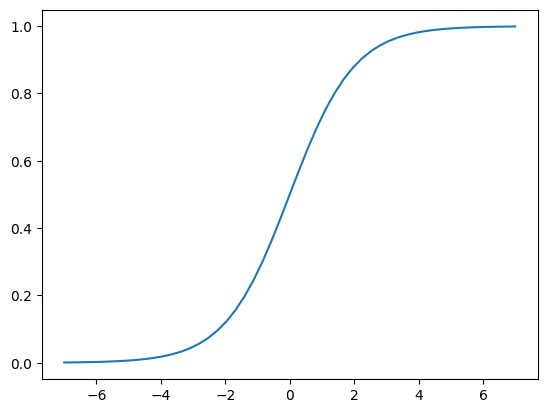

In [204]:
plt.plot(z, sigmoid(z))

In [205]:
from sklearn.linear_model import LogisticRegression

In [206]:
model = LogisticRegression(solver='lbfgs', max_iter=10000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=10000)

In [207]:
model.intercept_[0]

np.float64(-0.045323382519725265)

In [208]:
model.coef_[0].round(3)

array([ 0.685,  0.039, -0.682,  0.056, -0.015,  0.114, -0.16 ,  0.087,
        0.039,  0.002, -0.497,  0.698, -0.16 , -0.018, -0.187,  0.066,
        0.162,  0.117, -0.16 ,  0.084,  0.285, -0.16 , -0.084, -0.161,
        0.202, -0.045,  0.086, -0.052, -0.003,  0.106, -0.011,  0.066,
       -0.025,  0.194, -0.094, -0.16 ,  0.295, -0.054, -0.16 ,  0.255,
        0.235, -0.16 , -0.034, -0.069,  0.   ])

In [209]:
y_pred = model.predict_proba(X_val)[:, 1]
y_pred


array([0.0066238 , 0.20482253, 0.21781799, ..., 0.15149644, 0.78847856,
       0.81190391], shape=(1409,))

In [210]:
churn_decision = (y_pred >= 0.5)
df_val[churn_decision].customerid

3       8433-wxgna
8       3440-jpscl
12      7228-omtpn
19      6711-fldfb
24      2612-ranwt
           ...    
1397    5976-jcjrh
1398    2034-cgrhz
1399    5276-kqwhg
1407    6521-yytyi
1408    3049-solay
Name: customerid, Length: 315, dtype: object

In [211]:
(y_val == churn_decision).mean()

np.float64(0.8034066713981547)

In [212]:
df_pred = pd.DataFrame()
df_pred['probability'] = y_pred
df_pred['prediction'] = churn_decision.astype(int)
df_pred['actual'] = y_val
df_pred['correct'] = df_pred.prediction == df_pred.actual
df_pred.correct.mean()


np.float64(0.8034066713981547)

In [213]:
churn_decision.astype(int)

array([0, 0, 0, ..., 0, 1, 1], shape=(1409,))

In [214]:
dict(zip(dv.get_feature_names_out(), model.coef_[0].round(3)))

{'contract=month-to-month': np.float64(0.685),
 'contract=one_year': np.float64(0.039),
 'contract=two_year': np.float64(-0.682),
 'dependents=no': np.float64(0.056),
 'dependents=yes': np.float64(-0.015),
 'deviceprotection=no': np.float64(0.114),
 'deviceprotection=no_internet_service': np.float64(-0.16),
 'deviceprotection=yes': np.float64(0.087),
 'gender=female': np.float64(0.039),
 'gender=male': np.float64(0.002),
 'internetservice=dsl': np.float64(-0.497),
 'internetservice=fiber_optic': np.float64(0.698),
 'internetservice=no': np.float64(-0.16),
 'monthlycharges': np.float64(-0.018),
 'multiplelines=no': np.float64(-0.187),
 'multiplelines=no_phone_service': np.float64(0.066),
 'multiplelines=yes': np.float64(0.162),
 'onlinebackup=no': np.float64(0.117),
 'onlinebackup=no_internet_service': np.float64(-0.16),
 'onlinebackup=yes': np.float64(0.084),
 'onlinesecurity=no': np.float64(0.285),
 'onlinesecurity=no_internet_service': np.float64(-0.16),
 'onlinesecurity=yes': np.flo

In [215]:
small = ['contract', 'tenure', 'monthlycharges']

In [216]:
dicts_train_small = df_train[small].to_dict(orient='records')
dicts_val_small = df_val[small].to_dict(orient='records')

In [217]:
dv_small = DictVectorizer(sparse=False)
dv_small.fit(dicts_train_small)

DictVectorizer(sparse=False)

In [218]:
dv_small.get_feature_names_out()

array(['contract=month-to-month', 'contract=one_year',
       'contract=two_year', 'monthlycharges', 'tenure'], dtype=object)

In [219]:
X_train_small = dv_small.transform(dicts_train_small)

In [220]:
model_small = LogisticRegression()
model_small.fit(X_train_small, y_train)

LogisticRegression()

In [221]:
model_small.intercept_[0]

np.float64(-2.477957595829565)

In [222]:
w = model_small.coef_[0]
w.round(3)

array([ 0.971, -0.024, -0.948,  0.027, -0.036])

In [223]:
dict(zip(dv_small.get_feature_names_out(), w.round(3)))

{'contract=month-to-month': np.float64(0.971),
 'contract=one_year': np.float64(-0.024),
 'contract=two_year': np.float64(-0.948),
 'monthlycharges': np.float64(0.027),
 'tenure': np.float64(-0.036)}

In [224]:
-2.47 + (-0.949) + 30 * 0.027 + 24 * (-0.036)

-3.473

In [225]:
sigmoid(_)

np.float64(0.030090303318277657)

### 3.12 Using the model

In [137]:
dicts_full_train = df_full_train[categorical + numerical].to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_full_train = dv.fit_transform(dicts_full_train)

In [139]:
y_full_train = df_full_train.churn.values

In [162]:
model = LogisticRegression(max_iter=5000)
model.fit(X_full_train, y_full_train)

LogisticRegression(max_iter=5000)

In [163]:
dicts_test = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(dicts_test)
y_pred = model.predict_proba(X_test)[:,1]
churn_decision = (y_pred >= 0.5)
(churn_decision == y_test).mean()

np.float64(0.8105039034776437)

In [169]:
customer = dicts_test[-1]
customer

{'gender': 'female',
 'seniorcitizen': 0,
 'partner': 'yes',
 'dependents': 'yes',
 'phoneservice': 'yes',
 'multiplelines': 'yes',
 'internetservice': 'fiber_optic',
 'onlinesecurity': 'yes',
 'onlinebackup': 'no',
 'deviceprotection': 'yes',
 'techsupport': 'no',
 'streamingtv': 'yes',
 'streamingmovies': 'yes',
 'contract': 'month-to-month',
 'paperlessbilling': 'yes',
 'paymentmethod': 'electronic_check',
 'tenure': 17,
 'monthlycharges': 104.2,
 'totalcharges': 1743.5}

In [170]:
X_small = dv.transform([customer])
model.predict_proba(X_small)[0,1]

np.float64(0.6375704661276868)

In [171]:
y_test[-1]

np.int64(1)